In [1]:
# ========================
# 0. IMPORTS
# ========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Dense, LSTM, RepeatVector, 
                                     TimeDistributed, Dropout, Bidirectional,MultiHeadAttention, Attention, Concatenate,Multiply, LayerNormalization, Add,GlobalMaxPooling1D,GlobalAveragePooling1D)
from tensorflow.keras.callbacks import EarlyStopping
import joblib
from tensorflow.keras.optimizers import Adam

In [2]:
# ========================
# 1. CONFIGURATION
# ========================
INPUT_STEPS = 32
FORECAST_STEPS = 32
TEST_RATIO = 0.2
EPOCHS_LIST = [100]
BATCH_SIZES = [128]
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
# ========================
# 2. LOAD AND PREPROCESS DATA
# ========================
df = pd.read_csv('../../../data/preprocessed_data.csv')
df['DateTime'] = pd.to_datetime(df['DateTime'])
df.set_index('DateTime', inplace=True)
df.drop(columns=['labels'], inplace=True)
df.dropna(axis=1, thresh=int(0.7 * len(df)), inplace=True)
df.ffill(inplace=True)
df.bfill(inplace=True)


In [4]:
# List of columns to drop (replace with your actual column names)
columns_to_drop = ['500UZ0009E01.LZI0012A.MEAS', '505D002D01.TI0012.MEAS', '530K001S01.FI0007.MEAS','530R001D01.FIC0029.MEAS']

# Drop them from both train and test dataframes
df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

scaler = MinMaxScaler()
#scaler = RobustScaler()
scaled_data = scaler.fit_transform(df.values)
df_scaled = pd.DataFrame(scaled_data, index=df.index, columns=df.columns).astype(np.float32)
joblib.dump(scaler, "forecast_scaler.pkl")

# ========================
# 3. CREATE SEQUENCES
# ========================
def create_sequences(data, input_steps, forecast_steps):
    X, y = [], []
    for i in range(0, len(data) - input_steps - forecast_steps + 1, input_steps):
        X.append(data[i:i+input_steps])
        y.append(data[i+input_steps:i+input_steps+forecast_steps])
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

split_idx = int((1 - TEST_RATIO) * len(df_scaled))
train_data = df_scaled.iloc[:split_idx]
test_data = df_scaled.iloc[split_idx:]

X_train_seq, y_train_seq = create_sequences(train_data.values, INPUT_STEPS, FORECAST_STEPS)
X_test_seq, y_test_seq = create_sequences(test_data.values, INPUT_STEPS, FORECAST_STEPS)

In [5]:
df.shape

(30103, 22)

In [6]:
# ========================

def build_lstm_attention_model1(input_steps, forecast_steps, input_dim, units=128):
    encoder_inputs = Input(shape=(input_steps, input_dim))
    encoder_outputs, forward_h, forward_c, backward_h, backward_c = Bidirectional(
        LSTM(units, return_sequences=True, return_state=True)
    )(encoder_inputs)

    # Use average encoder output as decoder input context
    context_vector = tf.reduce_mean(encoder_outputs, axis=1)
    decoder_inputs = RepeatVector(forecast_steps)(context_vector)

    decoder_lstm = LSTM(units * 2, return_sequences=True)
    decoder_outputs = decoder_lstm(decoder_inputs,
                                   initial_state=[Concatenate()([forward_h, backward_h]),
                                                  Concatenate()([forward_c, backward_c])])

    attention = MultiHeadAttention(num_heads=4, key_dim=units)
    attention_output = attention(query=decoder_outputs, value=encoder_outputs, key=encoder_outputs)

    combined = Concatenate()([decoder_outputs, attention_output])
    combined = LayerNormalization()(combined)

    output = TimeDistributed(Dense(input_dim))(combined)

    model = Model(inputs=encoder_inputs, outputs=output)
    model.compile(optimizer='adam', loss='mse')  # plain MSE for now
    return model

def build_lstm_attention_model2(input_steps, forecast_steps, input_dim, units=128):
    encoder_inputs = Input(shape=(input_steps, input_dim))  # ← This was missing
    encoder_outputs, state_h, state_c = LSTM(units, return_sequences=True, return_state=True)(encoder_inputs)

    context_vector = tf.reduce_mean(encoder_outputs, axis=1)
    decoder_inputs = RepeatVector(forecast_steps)(context_vector)

    decoder_lstm = LSTM(units, return_sequences=True)
    decoder_outputs = decoder_lstm(decoder_inputs, initial_state=[state_h, state_c])

    attention = MultiHeadAttention(num_heads=4, key_dim=units)
    attention_output = attention(query=decoder_outputs, value=encoder_outputs, key=encoder_outputs)

    combined = Concatenate()([decoder_outputs, attention_output])
    combined = LayerNormalization()(combined)

    output = TimeDistributed(Dense(input_dim))(combined)

    model = Model(inputs=encoder_inputs, outputs=output)
    model.compile(optimizer='adam', loss='mse')
    return model

def build_lstm_attention_model(input_steps, forecast_steps, input_dim, units=128):
    encoder_inputs = Input(shape=(input_steps, input_dim))  # ← This was missing
    encoder_outputs, state_h, state_c = LSTM(units, return_sequences=True, return_state=True)(encoder_inputs)

    context_vector = state_h
    decoder_inputs = RepeatVector(forecast_steps)(context_vector)

    decoder_lstm = LSTM(units, return_sequences=True)
    decoder_outputs = decoder_lstm(decoder_inputs, initial_state=[state_h, state_c])

    attention = MultiHeadAttention(num_heads=4, key_dim=units)
    attention_output = attention(query=decoder_outputs, value=encoder_outputs, key=encoder_outputs)

    combined = Concatenate()([decoder_outputs, attention_output])
    combined = LayerNormalization()(combined)

    output = TimeDistributed(Dense(input_dim))(combined)

    model = Model(inputs=encoder_inputs, outputs=output)
    model.compile(optimizer='adam', loss='mse')
    return model

In [7]:

# ========================
# 5. TRAINING
# ========================
best_val_rmse = np.inf
best_model = None

for epochs in EPOCHS_LIST:
    for batch_size in BATCH_SIZES:
        print(f"\nTraining with epochs={epochs}, batch_size={batch_size}")
        model = build_lstm_attention_model(INPUT_STEPS, FORECAST_STEPS, X_train_seq.shape[2])
        es = EarlyStopping(patience=30, restore_best_weights=True)

        history = model.fit(X_train_seq, y_train_seq,
                            validation_split=0.1,
                            epochs=epochs,
                            batch_size=batch_size,
                            callbacks=[es],
                            verbose=1,
                            shuffle=False)

        val_preds = model.predict(X_test_seq, batch_size=batch_size)
        val_rmse = np.sqrt(mean_squared_error(y_test_seq.reshape(-1), val_preds.reshape(-1)))

        print(f"Validation RMSE: {val_rmse:.5f}")
        if val_rmse < best_val_rmse:
            best_val_rmse = val_rmse
            best_model = model


Training with epochs=100, batch_size=128
Epoch 1/100
6/6 [==============================] - 16s 329ms/step - loss: 0.9366 - val_loss: 0.3009
Epoch 2/100
6/6 [==============================] - 0s 49ms/step - loss: 0.2238 - val_loss: 0.0832
Epoch 3/100
6/6 [==============================] - 0s 44ms/step - loss: 0.1103 - val_loss: 0.0455
Epoch 4/100
6/6 [==============================] - 0s 43ms/step - loss: 0.0383 - val_loss: 0.0475
Epoch 5/100
6/6 [==============================] - 0s 45ms/step - loss: 0.0371 - val_loss: 0.0094
Epoch 6/100
6/6 [==============================] - 0s 44ms/step - loss: 0.0211 - val_loss: 0.0134
Epoch 7/100
6/6 [==============================] - 0s 43ms/step - loss: 0.0140 - val_loss: 0.0095
Epoch 8/100
6/6 [==============================] - 0s 45ms/step - loss: 0.0140 - val_loss: 0.0066
Epoch 9/100
6/6 [==============================] - 0s 45ms/step - loss: 0.0100 - val_loss: 0.0050
Epoch 10/100
6/6 [==============================] - 0s 45ms/step - loss: 0

In [8]:
val_preds.shape

(187, 32, 22)

In [9]:
46*32

1472

In [10]:
# ========================
# 6. SAVE MODEL
# ========================
best_model.save("best_lstm_attention_forecaster.h5")

In [11]:
X_train_seq.shape

(751, 32, 22)

In [12]:
892*32

28544

In [13]:
train_data.shape

(24082, 22)

1/1 [==============================] - 0s 66ms/step


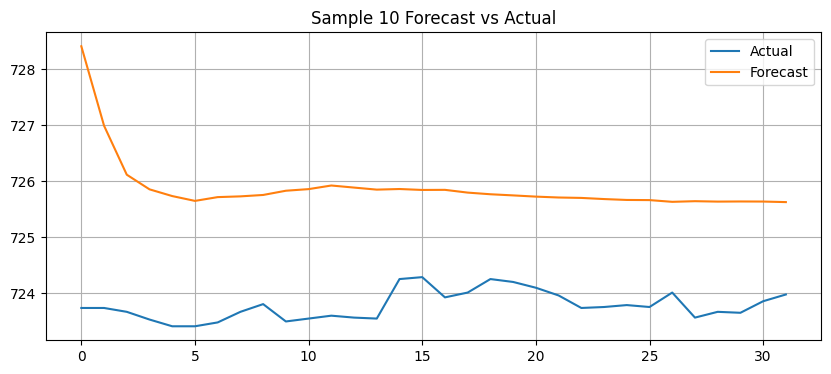

1/1 [==============================] - 0s 50ms/step


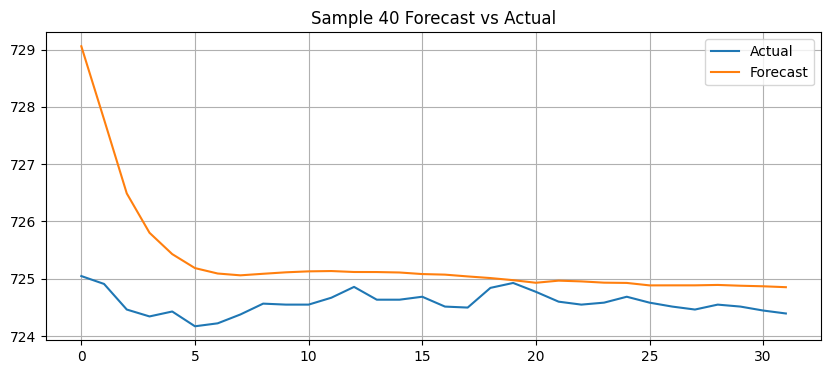

In [14]:
# ========================
# 7. EVALUATION AND PLOTTING
# ========================
def evaluate_sample(index):
    input_seq = np.expand_dims(X_test_seq[index], axis=0)
    prediction = best_model.predict(input_seq)
    pred = prediction.reshape(-1, prediction.shape[2])
    actual = y_test_seq[index]

    pred_denorm = scaler.inverse_transform(pred)
    actual_denorm = scaler.inverse_transform(actual)

    plt.figure(figsize=(10, 4))
    plt.plot(actual_denorm[:, 13], label='Actual')
    plt.plot(pred_denorm[:, 13], label='Forecast')
    plt.title(f'Sample {index} Forecast vs Actual')
    plt.legend()
    plt.grid(True)
    plt.show()

# Compare two samples visually
evaluate_sample(10)
evaluate_sample(40)


In [15]:
y_test_seq.shape

(187, 32, 22)

In [16]:
X_train_seq.shape

(751, 32, 22)

In [17]:
#y_pred_reshaped2 = X_test_seq[6197].reshape(-1, X_test_seq[6197].shape[2])
denorm2 = scaler.inverse_transform(X_train_seq[200])
denorm_df2 = pd.DataFrame(denorm2, columns=df.columns)

In [18]:
input_seq1 = np.expand_dims(X_train_seq[199], axis=0)
val_preds2 = model.predict(input_seq1, batch_size=128)
y_pred_reshaped = val_preds2.reshape(-1, val_preds2.shape[2])
denorm = scaler.inverse_transform(y_pred_reshaped)
denorm_df = pd.DataFrame(denorm, columns=df.columns)

1/1 [==============================] - 0s 43ms/step


In [19]:
denorm_df2

,520MX051D01.FIC0028.MEAS,520D007D02.TI0058.MEAS,530R001D01.FI0043.MEAS,530E001D01.FIC0015.MEAS,530R001D01.FIC0030.MEAS,530R001D01.FIC0047.MEAS,530C021D01.FIC0203.MEAS,530R001D02.FIC0230.MEAS,530R002D02.LI0010.MEAS,530M102D01.LIC0011.MEAS,...,530F001D01.PIC0023.MEAS,530R002D02.TI0037.MEAS,530F001D01.TIC0012.MEAS,530M105D01.TIC0022.MEAS,530UZ1099E01.TZI0068A.MEAS,530M103D01.ZI2103A.MEAS,530M104D01.ZI2104A.MEAS,530M105D01.ZI2105A.MEAS,535D005D01.LI0011.MEAS,535INT920D01.TI0046.MEAS
0,4.464233,125.085938,2648.907959,1199.172852,2565.464355,311.602051,130.519760,7.065649,48.037071,30.386353,...,1.495781,725.098450,142.015625,680.985352,157.829681,20.193357,20.8125,60.482422,13.231329,57.972656
1,4.464233,124.968750,2646.629395,1199.993530,2557.561035,310.043182,130.696701,6.964700,48.668304,30.555983,...,1.495781,725.115662,142.000000,681.430664,157.698410,20.162109,20.8125,60.384762,13.110781,57.972656
2,4.464233,125.074219,2657.194336,1199.076172,2562.685791,309.076019,130.436874,6.964700,50.008850,30.704868,...,1.495781,725.184387,141.875000,681.292969,157.567169,20.162109,20.8125,60.792969,13.215003,57.972656
3,4.464233,125.179688,2660.478027,1200.289673,2560.506836,308.995544,130.460434,6.964700,49.459541,29.173666,...,1.495781,725.562500,141.890625,681.632812,157.829681,19.925781,20.8125,60.482422,13.204456,57.871094
4,4.464233,125.285164,2653.943359,1200.520142,2563.290527,311.540802,130.061737,6.964700,48.033115,27.996922,...,1.495781,725.923462,141.953125,682.245117,158.092194,20.015623,20.8125,60.072266,13.106637,57.871094
5,4.464233,125.712891,2647.661621,1198.032227,2547.954102,308.944061,130.661072,6.964700,48.248726,30.699545,...,1.495781,725.287537,142.125000,681.902344,158.485962,20.031250,20.8125,60.244144,13.106637,57.978516
6,4.464233,125.935547,2652.317871,1202.029419,2551.468262,308.815796,130.479111,6.964700,48.709831,32.345230,...,1.495781,725.321899,142.187500,681.041016,158.354706,19.830076,20.8125,60.207031,13.214907,57.978516
7,4.464233,126.152344,2654.146973,1200.358276,2551.918701,310.398071,130.431320,6.964700,49.583298,29.487225,...,1.495781,725.459412,142.375000,680.510742,158.092194,20.501953,20.8125,60.722656,13.212667,58.080078
8,4.464233,126.152344,2642.101074,1198.166504,2542.290283,311.755768,130.576660,6.964700,49.437325,27.602104,...,1.495781,725.957825,142.250000,682.063477,157.960922,20.888672,20.8125,60.611324,13.005109,57.869137
9,4.464233,126.152344,2648.543701,1199.959839,2547.854248,308.923798,130.309143,6.964700,48.487881,29.217525,...,1.495781,725.700012,142.171875,682.734375,158.092194,20.435547,20.8125,60.449223,13.109384,57.869137


In [20]:
denorm_df

,520MX051D01.FIC0028.MEAS,520D007D02.TI0058.MEAS,530R001D01.FI0043.MEAS,530E001D01.FIC0015.MEAS,530R001D01.FIC0030.MEAS,530R001D01.FIC0047.MEAS,530C021D01.FIC0203.MEAS,530R001D02.FIC0230.MEAS,530R002D02.LI0010.MEAS,530M102D01.LIC0011.MEAS,...,530F001D01.PIC0023.MEAS,530R002D02.TI0037.MEAS,530F001D01.TIC0012.MEAS,530M105D01.TIC0022.MEAS,530UZ1099E01.TZI0068A.MEAS,530M103D01.ZI2103A.MEAS,530M104D01.ZI2104A.MEAS,530M105D01.ZI2105A.MEAS,535D005D01.LI0011.MEAS,535INT920D01.TI0046.MEAS
0,4.380447,126.291946,2647.913330,1171.519775,2538.264160,312.073486,127.751053,6.899696,50.029144,27.683575,...,1.536872,725.349182,139.299347,677.981812,157.724731,19.450407,21.817160,60.107971,13.256989,57.943016
1,4.459982,121.325348,2654.142578,1196.591919,2556.628662,312.032043,131.119431,6.887599,48.784767,29.122303,...,1.522895,726.178772,145.643921,678.281250,157.924942,19.793446,22.133047,60.195351,13.233667,57.852165
2,4.493509,120.834145,2655.443848,1196.838501,2562.164062,311.890625,131.685120,6.849689,48.119965,29.333052,...,1.524273,726.619080,145.494156,678.630554,157.895355,20.050823,21.616592,59.992050,13.188793,57.863663
3,4.509439,121.872070,2655.626221,1196.659424,2564.458008,311.675873,131.396927,6.816402,47.956139,29.308582,...,1.522371,726.883911,143.954987,679.046448,158.100723,20.122980,21.154152,59.690289,13.170182,57.890526
4,4.515419,122.514511,2655.888672,1198.227417,2566.985352,311.520264,131.193985,6.793350,47.979187,29.287010,...,1.518346,726.909241,143.659485,679.457336,158.316391,20.127949,20.956566,59.491833,13.163522,57.896767
5,4.516145,122.356133,2656.173584,1200.273193,2568.831787,311.417358,131.190903,6.772632,48.123325,29.308931,...,1.514664,726.856567,144.415161,679.844543,158.417404,20.128567,20.891060,59.425793,13.158668,57.884312
6,4.517471,122.023209,2656.527832,1202.793579,2570.408447,311.381622,131.320892,6.758623,48.285885,29.362352,...,1.512568,726.867615,146.105637,680.116272,158.389145,20.130131,20.870052,59.401260,13.151008,57.861717
7,4.518279,121.647987,2656.658203,1204.386108,2570.899170,311.383453,131.511993,6.747713,48.440338,29.433386,...,1.511295,726.872009,147.317581,680.261597,158.330750,20.135115,20.855888,59.391636,13.142401,57.841457
8,4.519461,121.545906,2656.709229,1205.706665,2571.477539,311.365906,131.645432,6.741140,48.560394,29.523901,...,1.511404,726.888672,148.345016,680.337097,158.231232,20.129396,20.830627,59.431030,13.136692,57.830433
9,4.519070,121.414894,2656.626709,1206.150879,2571.666504,311.401001,131.752640,6.736453,48.612022,29.543451,...,1.511133,726.935547,148.993698,680.377319,158.125443,20.128288,20.807562,59.471848,13.132788,57.828251


In [21]:
# ========================
# 6. FORECAST TRAINING SEQUENCES
# ========================

# Generate forecasts for all training sequences
train_forecasts = best_model.predict(X_train_seq, batch_size=BATCH_SIZES[0])

# Reshape forecasts to (n_samples, n_features)
n_sequences = train_forecasts.shape[0]
forecast_samples = train_forecasts.reshape(-1, train_forecasts.shape[2])

# Create corresponding timestamps for forecasts
# Calculate the start time for each forecast window
start_times = train_data.index[INPUT_STEPS : INPUT_STEPS + n_sequences * INPUT_STEPS : INPUT_STEPS]

# Create datetime range for each forecast
forecast_dates = []
for start in start_times:
    forecast_dates.extend(pd.date_range(start=start, periods=FORECAST_STEPS, freq='min'))  # Adjust freq if needed

# Create DataFrame with the same columns as original
forecast_df = pd.DataFrame(forecast_samples, 
                          index=forecast_dates[:len(forecast_samples)],  # Ensure same length
                          columns=df.columns)

# Inverse transform to original scale
forecast_df = pd.DataFrame(scaler.inverse_transform(forecast_df), 
                          index=forecast_df.index, 
                          columns=forecast_df.columns)

# ========================
# 7. SAVE FORECASTS
# ========================

# Save with DateTime index
forecast_df.to_csv('../../../data/training_sequence_forecasts.csv', index=True, index_label='DateTime')

print(f"Saved {len(forecast_df)} forecasts to 'training_sequence_forecasts.csv'")
print("Sample of forecast data:")
print(forecast_df.head())

6/6 [==============================] - 0s 17ms/step
Saved 24032 forecasts to 'training_sequence_forecasts.csv'
Sample of forecast data:
                     520MX051D01.FIC0028.MEAS  520D007D02.TI0058.MEAS  \
2024-10-05 01:51:00                  4.721277              102.855568   
2024-10-05 01:52:00                  4.519205               92.765091   
2024-10-05 01:53:00                  4.428276               90.573135   
2024-10-05 01:54:00                  4.398027               92.371719   
2024-10-05 01:55:00                  4.391092               94.494629   

                     530R001D01.FI0043.MEAS  530E001D01.FIC0015.MEAS  \
2024-10-05 01:51:00             2673.515381              1205.265137   
2024-10-05 01:52:00             2673.594971              1152.284546   
2024-10-05 01:53:00             2669.638672              1109.010864   
2024-10-05 01:54:00             2667.239502              1089.760010   
2024-10-05 01:55:00             2666.472412              1085.797

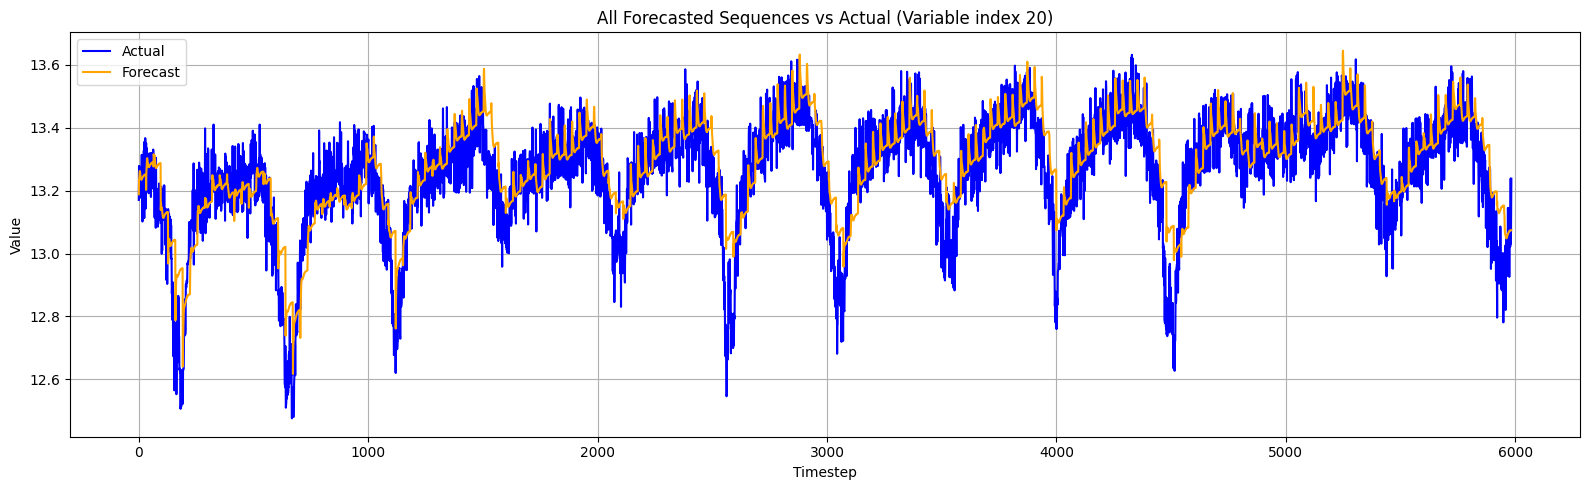

In [23]:
def plot_all_forecasts_on_one_graph(variable_index=13):
    all_actual = []
    all_predicted = []

    for index in range(len(X_test_seq)):
        input_seq = np.expand_dims(X_test_seq[index], axis=0)
        prediction = best_model.predict(input_seq, verbose=0)
        pred = prediction.reshape(-1, prediction.shape[2])
        actual = y_test_seq[index]

        pred_denorm = scaler.inverse_transform(pred)
        actual_denorm = scaler.inverse_transform(actual)

        all_actual.extend(actual_denorm[:, variable_index])
        all_predicted.extend(pred_denorm[:, variable_index])

    plt.figure(figsize=(16, 5))
    plt.plot(all_actual, label='Actual', color='blue')
    plt.plot(all_predicted, label='Forecast', color='orange')
    plt.title(f'All Forecasted Sequences vs Actual (Variable index {variable_index})')
    plt.xlabel('Timestep')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Appel de la fonction
plot_all_forecasts_on_one_graph(20)